In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
vk = pd.read_csv('../datasets/vk_interests_finance.csv')
vk.head(10)

,first_name,last_name,sex,age,city_id,has_high_education,relation,num_of_relatives,followers_count,status,...,top3,top3_mean,game_sum,is_gamer,parent_sum,is_parent,driver_sum,is_driver,pets_sum,has_pets
0,Darya,Tsiberkina,1.0,33,2,0,4,2,486,8,...,5812,1277.784568,0.0,0,9968.00,1,0.0,0,0.0,0
1,Gleb,Kotenev,2.0,18,2,0,0,2,0,5,...,5814,384.000000,0.0,0,0.00,0,0.0,0,0.0,0
2,Anna,Pavlova,1.0,34,2,0,0,2,7,0,...,6011,24000.000000,0.0,0,0.00,0,0.0,0,0.0,0
3,Serega,Martynov,2.0,39,2,0,0,2,7,10,...,5411,142.175000,0.0,0,0.00,0,0.0,0,0.0,0
4,Maria,Pavlyukova,1.0,0,2,0,0,2,144,0,...,6011,1095.238095,0.0,0,60331.59,1,0.0,0,80.0,0
5,Yury,Golubkov,2.0,47,2,0,0,2,0,0,...,5964,760.580000,0.0,0,0.00,0,0.0,0,0.0,0
6,Svetlana,Muratova,1.0,48,2,0,4,2,30,0,...,5411,113.000000,0.0,0,0.00,0,0.0,0,0.0,0
7,Ivan,Poletaev,2.0,0,2,0,0,2,53,23,...,5411,446.565263,1000.0,1,0.00,0,0.0,0,0.0,0
8,Anastasia,Yaguzhinskaya,1.0,25,1,0,0,2,111,3,...,5499,185.523529,0.0,0,0.00,0,0.0,0,1287.0,0
9,Valentina,Trokhova,1.0,55,2,0,0,12,56,0,...,5499,345.572472,0.0,0,0.00,0,0.0,0,0.0,0


In [4]:
vk.columns

Index(['first_name', 'last_name', 'sex', 'age', 'city_id',
       'has_high_education', 'relation', 'num_of_relatives', 'followers_count',
       'status', 'mobile_phone', 'twitter', 'facebook', 'instagram', 'about',
       'about_topic', 'activities', 'activities_topic', 'books', 'interests',
       'interests_topic', 'movies', 'music', 'quotes', 'personal_alcohol',
       'personal_life_main', 'personal_people_main', 'personal_political',
       'платье размер наличие цвет', 'массаж тело   йога',
       'игра команда место', 'цвет цветок букет интерьер',
       'iphone apple торт набор pro чехол',
       'клиент который проект интернет бизнес', 'год война время ссср армия',
       'волос маникюр   ресница', 'handmade ряд ручнаяработа что петля лицо',
       'работа год график день', 'концерт билет музыка рок группа',
       'лечение заболевание кровь врач болезнь',
       'школа искать год вопрос тема', 'кожа лицо масло волос',
       'книга язык слово', 'санкт петербург участие фест

In [5]:
vk = vk[['age', 'sex', 'relation', 'mean_tr', 'median_tr', 'tr_per_month', 'is_driver', 'is_parent', 'has_pets']]

In [6]:
vk['sex'] = vk['sex'].apply(lambda x: int(x))

In [7]:
nodes_type = get_nodes_type(vk)
nodes_type

{'age': 'disc',
 'sex': 'disc',
 'relation': 'disc',
 'mean_tr': 'cont',
 'median_tr': 'cont',
 'tr_per_month': 'cont',
 'is_driver': 'disc',
 'is_parent': 'disc',
 'has_pets': 'disc'}

In [8]:
vk.dropna(inplace=True)
vk.reset_index(inplace=True, drop=True)

In [9]:
vk_discrete, vk_coder = discretization(vk, 'equal_frequency', ['mean_tr', 'median_tr', 'tr_per_month'])

In [10]:
vk_discrete

,age,sex,relation,mean_tr,median_tr,tr_per_month,is_driver,is_parent,has_pets
0,33,1,4,2,2,4,0,1,0
1,18,2,0,0,0,2,0,0,0
2,34,1,0,3,4,0,0,0,0
3,39,2,0,4,2,2,0,0,0
4,0,1,0,0,0,2,0,1,0
...,...,...,...,...,...,...,...,...,...
93613,20,2,0,0,0,0,0,0,0
93614,47,1,0,3,3,4,0,1,0
93615,57,1,0,4,4,0,0,0,0
93616,58,2,4,4,3,1,0,1,0


In [11]:
bn = structure_learning(vk_discrete, 'K2', nodes_type)

  0%|          | 21/1000000 [00:03<51:57:25,  5.35it/s]


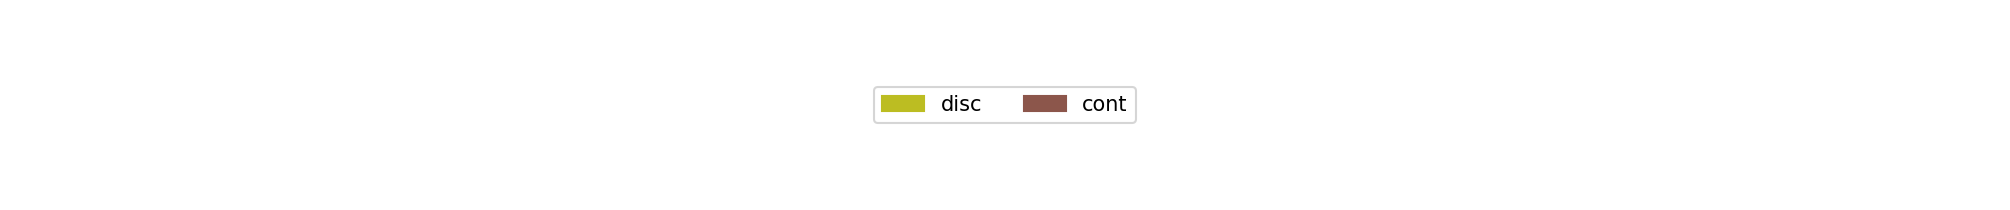

In [12]:
draw_BN(bn, nodes_type, 'vk_net')

In [13]:
params = parameter_learning(vk, nodes_type, bn)

In [14]:
save_structure(bn, 'cluster_net')
skel = read_structure('cluster_net')
save_params(params, 'cluster_net_param')
params = read_params('cluster_net_param')
vk_bn = HyBayesianNetwork(skel, params)

In [15]:
geo = pd.read_csv('../datasets/hackathon_processed.csv')
geo.head(10)

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Period,Lithology,Gross,Netpay,Porosity,Permeability
0,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,OIL,REJUVENATING,FORELAND,1815.0,JURASSIC,LIMESTONE,75.0,55.2,21.0,410.0
1,ABU GHARADIG,BAHARIYA,EGYPT,AFRICA,ABU GHARADIG,EXTENSION,29.7422,28.4925,GUPCO,ONSHORE,GAS-CONDENSATE,MATURE PRODUCTION,RIFT,3084.6,CRETACEOUS,SANDSTONE,223.5,43.2,10.0,8.0
2,ABU MADI-EL QARA,ABU MADI (LEVEL II),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP,31.4382,31.3616,IEOC,ONSHORE,GAS,DECLINING PRODUCTION,WRENCH,2952.9,NEOGENE,THINLY-BEDDED SANDSTONE,34.5,19.8,22.0,200.0
3,ABU MADI-EL QARA,ABU MADI (LEVEL III),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP,31.4382,31.3616,IEOC,ONSHORE,GAS,DECLINING PRODUCTION,WRENCH,3149.7,NEOGENE,SANDSTONE,152.7,123.0,20.0,300.0
4,AL HUWAISAH,SHUAIBA,OMAN,MIDDLE EAST,FAHUD SALT,COMPRESSION,21.9607,56.0452,PDO,ONSHORE,OIL,REJUVENATING,SALT,1486.5,CRETACEOUS,LIMESTONE,75.0,30.0,21.0,60.0
5,ALABAMA FERRY,UPPER GLEN ROSE D ZONE,USA,NORTH AMERICA,GULF OF MEXICO NORTHERN ONSHORE,GRAVITY,31.2143,-95.7981,NUMEROUS,ONSHORE,OIL,MATURE PRODUCTION,PASSIVE MARGIN,2610.0,CRETACEOUS,LIMESTONE,28.5,4.5,12.0,20.0
6,ALBA,ALBA,UK,EUROPE,NORTH SEA CENTRAL,NaN,58.0692,1.0784,CHEVRON,OFFSHORE,OIL,DECLINING PRODUCTION,RIFT,1692.6,PALEOGENE,THINLY-BEDDED SANDSTONE,90.0,81.0,NaN,3500.0
7,ALBION-SCIPIO,TRENTON-BLACK RIVER,USA,NORTH AMERICA,MICHIGAN,NaN,41.9937,-84.6016,NUMEROUS,ONSHORE,OIL,NEARLY DEPLETED,INTRACRATONIC,1140.0,ORDOVICIAN,DOLOMITE,180.0,120.0,NaN,10.0
8,ALIBEKMOLA,KT I,KAZAKHSTAN,FORMER SOVIET UNION,CASPIAN NORTH,COMPRESSION,48.4740,57.6667,KAZAKHOIL AKTOBE,ONSHORE,OIL,DEVELOPING,SUB-SALT,1800.0,CARBONIFEROUS,LIMESTONE,90.0,31.5,10.0,20.0
9,ALIBEKMOLA,KT II,KAZAKHSTAN,FORMER SOVIET UNION,CASPIAN NORTH,COMPRESSION,48.4740,57.6667,KAZAKHOIL AKTOBE,ONSHORE,OIL,DEVELOPING,SUB-SALT,2874.0,CARBONIFEROUS,LIMESTONE,182.1,32.4,10.0,20.0


In [16]:
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross','Netpay','Porosity','Permeability', 'Depth']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [17]:
geo_discrete, geo_coder = discretization(geo, 'equal_frequency', ['Gross','Netpay','Porosity','Permeability', 'Depth'])

In [18]:
geo_nodes = get_nodes_type(geo)
geo_nodes

{'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Gross': 'cont',
 'Netpay': 'cont',
 'Porosity': 'cont',
 'Permeability': 'cont',
 'Depth': 'cont'}

In [19]:
bn_geo = structure_learning(geo_discrete, 'K2', geo_nodes)

  0%|          | 11/1000000 [00:01<36:55:11,  7.52it/s]


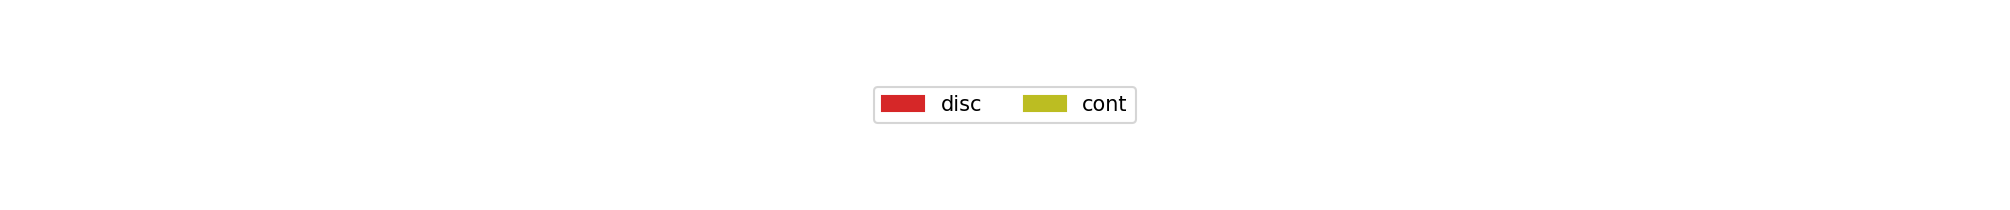

In [20]:
draw_BN(bn_geo, geo_nodes, 'geo_net')

In [21]:
params_geo = parameter_learning(geo, geo_nodes, bn_geo)

In [22]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params_geo, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [23]:
geo_sand = geo.loc[geo['Lithology'] == 'SANDSTONE']
geo_sand

,Tectonic regime,Period,Lithology,Structural setting,Gross,Netpay,Porosity,Permeability,Depth
1,EXTENSION,CRETACEOUS,SANDSTONE,RIFT,223.5,43.2,10.0,8.0,3084.6
3,STRIKE-SLIP,NEOGENE,SANDSTONE,WRENCH,152.7,123.0,20.0,300.0,3149.7
8,COMPRESSION,JURASSIC,SANDSTONE,FORELAND,15.0,14.7,20.0,15.0,1980.0
9,COMPRESSION,PALEOGENE,SANDSTONE,FORELAND,2400.0,172.5,5.0,0.1,4575.0
10,INVERSION,JURASSIC,SANDSTONE,RIFT,265.8,103.2,17.0,500.0,2937.0
...,...,...,...,...,...,...,...,...,...
433,GRAVITY,NEOGENE,SANDSTONE,DELTA,57.0,30.0,27.0,2000.0,1320.0
437,EXTENSION,PALEOGENE,SANDSTONE,RIFT,69.0,20.7,26.7,1872.0,1615.2
438,EXTENSION,PALEOGENE,SANDSTONE,RIFT,49.2,18.6,23.2,121.0,1416.3
440,COMPRESSION,CARBONIFEROUS,SANDSTONE,FORELAND,78.6,9.9,24.0,30.0,561.0


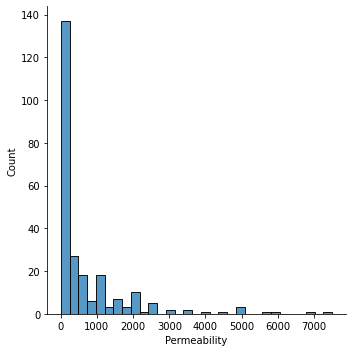

In [24]:
sns.displot(geo_sand['Permeability'])

In [25]:
geo_sand = geo_sand.sort_values(by=['Porosity'])

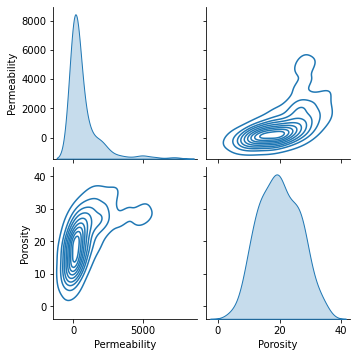

In [26]:
sns.pairplot(geo_sand[['Permeability', 'Porosity']], kind="kde")

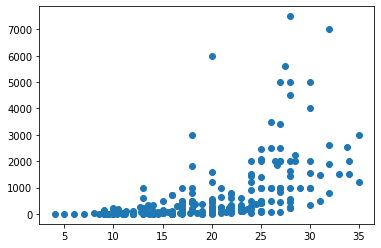

In [27]:
plt.scatter(geo_sand['Porosity'], geo_sand['Permeability'])

In [28]:
stats.kstest(geo_sand['Permeability'].values, 'norm')

KstestResult(statistic=0.9421984890651441, pvalue=1.828016415084089e-307)

In [29]:
import operator
from copy import copy
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import accuracy_score, mean_squared_error
from external.libpgm.sampleaggregator import SampleAggregator
from preprocess.discretization import get_nodes_type
from external.libpgm.hybayesiannetwork import HyBayesianNetwork


def calculate_acc(bn: HyBayesianNetwork, data: pd.DataFrame, columns: list) -> (dict, dict):
    """Function for calculating of params restoration accuracy

    Args:
        bn (HyBayesianNetwork): fitted BN
        data (pd.DataFrame): test dataset
        columns (list): list of params for restoration

    Returns:
        dict: accuracy score (discrete vars)
        dict: rmse score (continuous vars)
        float: density of BN graph
    """

    accuracy_dict = dict()
    rmse_dict = dict()
    pred_param = [[0 for j in range(data.shape[0])] for i in range(len(columns))]
    real_param = [[0 for j in range(data.shape[0])] for i in range(len(columns))]
    data = data[columns]
    node_type = get_nodes_type(data)
    for i in range(data.shape[0]):
        test = dict(data.iloc[i, :])
        for n, key in enumerate(columns):
            train_dict = copy(test)
            train_dict.pop(key)
           
            if node_type[key] == 'disc':
                agg = SampleAggregator()
                sample = agg.aggregate(bn.randomsample(2000, train_dict))
                sorted_res = sorted(sample[key].items(), key=operator.itemgetter(1), reverse=True)
                pred_param[n][i] = sorted_res[0][0]
                real_param[n][i] = test[key]
            if node_type[key] == 'cont':
                sample = pd.DataFrame(bn.randomsample(2000, train_dict))
                sample = sample.loc[sample[key] >= 0]
                if sample.shape[0] == 0:
                    print(i)
                else:
                    pred = np.mean(sample[key].values)
                    pred_param[n][i] = pred
                    real_param[n][i] = test[key]
            
    for n, key in enumerate(columns):
        if node_type[key] == 'disc':
            accuracy_dict[key] = round(accuracy_score(real_param[n], pred_param[n]), 2)
        if node_type[key] == 'cont':
            rmse_dict[key] = round(mean_squared_error(real_param[n], pred_param[n], squared=False), 2)
    return accuracy_dict, rmse_dict

78: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\anaxa\AppData\Local\Programs\Python\Python

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').